In [16]:
#
##
### LOAD DATA

import pandas as pd
import numpy as np

def _optimize_numeric_dtypes(df):
    import pandas as pd
    float_cols = df.select_dtypes("float").columns
    int_cols = df.select_dtypes("integer").columns
    df[float_cols] = df[float_cols].\
        apply(pd.to_numeric, downcast="float")
    df[int_cols] = df[int_cols].\
        apply(pd.to_numeric, downcast="integer")
    return df

data = _optimize_numeric_dtypes(
    pd.read_parquet("../data/customer_model/retailrocket/"))
#data["target_cap"] = data["target_cap"].clip(-1000,10000)

#
##
### CONSTRUCT PROFIT TARGET
# NOTE: encapsulate this
config = {
    "gamma":{"alpha":2.04, "beta":202.04},
    "delta":7500, 
    "psi":{"alpha":6.12, "beta":3.15},
    "n_iter":1000,
    "seed":1}
    
gamma = config["gamma"]
delta = config["delta"]
psi = config["psi"]
n_iter = config["n_iter"]
seed = config["seed"] 

n_users = data.user_id.nunique()
sp = []
for i in range(n_iter):
    gamma_psi = pd.DataFrame.from_dict({
        "user_id":data.user_id.unique(),
        "gamma":np.random.beta(gamma["alpha"], gamma["beta"], size=n_users),
        "psi":np.random.beta(psi["alpha"], psi["beta"], size=n_users)})
    temp = data.merge(gamma_psi, on=["user_id"])
    temp["acp"] = (temp["target_event"]*temp["gamma"]*(temp["target_cap"]-delta)
        + (1-temp["target_event"])*(-temp["psi"]*delta))
    sp.append(temp.loc[:,["user_id", "week_step", "acp"]])
sp = pd.concat(sp)

In [17]:
out_cols = ["user_id", "row_id", "target_event",
    "target_revenue", "week_step", "target_cap", "cap"]
feat_cols = [c for c in data.columns if c not in set(out_cols)]
target_cols = ["acp"]
data = data.merge(sp.groupby(["user_id","week_step"], as_index=False).acp.mean(), on=["user_id","week_step"])

In [18]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import BaggingRegressor
from lightgbm import LGBMRegressor

trf = data.week_step>5
tef = data.week_step==5
X_train, y_train = data.loc[trf,feat_cols], data.loc[trf,target_cols]
X_test, y_test = data.loc[tef,feat_cols], data.loc[tef,target_cols]

# we bagg lgbm, to compensate the similar ensemble procedure in clf
lgbm = BaggingRegressor(base_estimator=LGBMRegressor(), n_estimators=5)
lgbm.fit(X_train, y_train)
r2_score(y_test, lgbm.predict(X_test))

/home/mf/github/churn-modeling/.env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py:470: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


0.6024142500961354

In [19]:
sp = X_test.copy()
sp["acp"] = y_test.loc[:,["acp"]]
sp["ecp"] = lgbm.predict(X_test)
sp = sp.sort_values("ecp", ascending=False)
sp["cecp"] = sp.ecp.cumsum()
sp["perc"] = sp.ecp.rank(ascending=False, pct=True)
sp["cacp"] = sp.acp.cumsum()

print("campaign size: {:.3f}".format(sp.perc[sp.cecp.idxmax()]))
print("expected campaign profit: {:.2f}".format( sp.cecp.max()))
print("actual campaign profit: {:.2f}".format(sp.cacp[sp.cecp.idxmax()]))

campaign size: 0.338
expected campaign profit: 94604.81
actual campaign profit: 96744.70


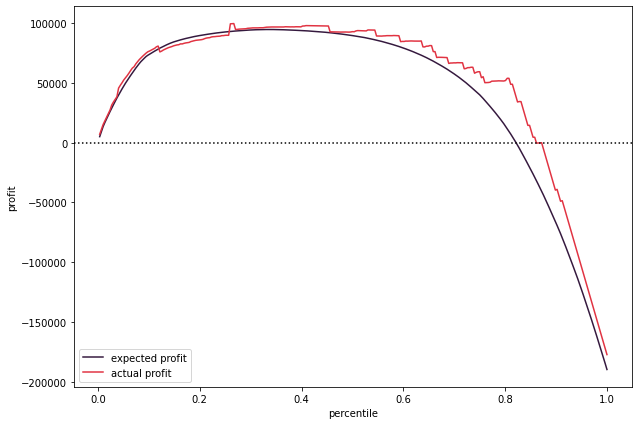

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_simulated_profit(sp):    
    f, a = plt.subplots(1,1, figsize=(10,7))
    sns.lineplot(#data=sp,
        x=sp.perc, y=sp.cecp, legend=False,
        color=sns.color_palette("rocket")[0], ax=a);
    sns.lineplot(#data=sp,
        x=sp.perc, y=sp.cacp, legend=False,
        color=sns.color_palette("rocket")[3], ax=a);
    a.set_ylabel("profit");
    a.set_xlabel("percentile");
    a.legend(loc="lower left",
        labels=["expected profit", "actual profit"]);
    a.axhline(0, linestyle="dotted", c="k");
    return None
plot_simulated_profit(sp)    